In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, AutoTokenizer, AutoModel
from transformers import Trainer, TrainingArguments
from tqdm import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import pickle
from sklearn.linear_model import LogisticRegression

2024-05-02 12:01:20.484127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 12:01:20.484306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 12:01:20.660224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
train_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/train.csv')
train_data.head(2)
train_text = train_data.Text
train_labels = train_data['Class']

In [18]:
train_labels = train_data['Class'].apply(lambda x: 1 if x == 'M' else 0)

In [19]:
train_text = train_text[100000:]
train_labels = train_labels[100000:]

In [4]:
model_name = "ai-forever/sbert_large_nlu_ru"
tokenizer = AutoTokenizer.from_pretrained(model_name, token_size=64)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
batch_size = 32

In [22]:
sentences = list(train_text)

In [23]:
sentences = sentences
train_labels = train_labels

In [24]:
train_labels

100000    0
100001    0
100002    0
100003    0
100004    0
         ..
129061    1
129062    0
129063    0
129064    1
129065    1
Name: Class, Length: 29066, dtype: int64

In [25]:
max_seq_length = 64
batches_processed = 0
amount_of_batches = len(sentences) // batch_size

In [6]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [6]:
# Save embeddings and labels to a file
def save_embeddings(embeddings, labels, filename):
    data = {
        'embeddings': embeddings,
        'labels': labels
    }
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Load embeddings and labels from a file
def load_embeddings(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data['embeddings'], data['labels']

In [28]:
def process_batch(batch_sentences):
    inputs = tokenizer(batch_sentences, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors="pt")
    global batches_processed
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embeddings = mean_pooling(outputs, inputs['attention_mask'])
    batches_processed += 1
    print(f"Processed {batches_processed} out of {amount_of_batches} batches", flush=True)
#     return outputs.last_hidden_state
    return sentence_embeddings

# Function to process batches and obtain embeddings
def process_batches(sentences, labels):
    embeddings_list = []
    label_list = []
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on available CPU cores
        for i in range(0, len(sentences), batch_size):
            batch_sentences = sentences[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            # Submit batch processing to ThreadPoolExecutor
            future = executor.submit(process_batch, batch_sentences)
            # Increment the counter for batches processed
            # Append the Future object to a list
            embeddings_list.append(future)
            label_list.extend(batch_labels)
    # Extract results from Future objects
    embeddings = torch.cat([future.result() for future in embeddings_list], dim=0)
    labels_tensor = torch.tensor(label_list)
    return embeddings, labels_tensor

In [29]:
# Obtain embeddings for the entire dataset
embeddings, labels = process_batches(sentences, train_labels)

# Convert PyTorch tensor to NumPy array
embeddings_numpy = embeddings.numpy()

# Print the shape of the embeddings
print("Embeddings shape:", embeddings_numpy.shape)

Processed 1 out of 908 batches
Processed 2 out of 908 batches
Processed 3 out of 908 batches
Processed 4 out of 908 batches
Processed 5 out of 908 batches
Processed 6 out of 908 batches
Processed 7 out of 908 batches
Processed 8 out of 908 batches
Processed 9 out of 908 batches
Processed 10 out of 908 batches
Processed 11 out of 908 batches
Processed 12 out of 908 batches
Processed 13 out of 908 batches
Processed 14 out of 908 batches
Processed 15 out of 908 batches
Processed 16 out of 908 batches
Processed 17 out of 908 batches
Processed 18 out of 908 batches
Processed 19 out of 908 batches
Processed 20 out of 908 batches
Processed 21 out of 908 batches
Processed 22 out of 908 batches
Processed 23 out of 908 batches
Processed 24 out of 908 batches
Processed 25 out of 908 batches
Processed 26 out of 908 batches
Processed 27 out of 908 batches
Processed 28 out of 908 batches
Processed 29 out of 908 batches
Processed 30 out of 908 batches
Processed 31 out of 908 batches
Processed 32 out 

In [30]:
# labels_numpy = labels.numpy()
save_embeddings(embeddings, labels, 'embeddings_train_data_ruatd_sbert_100000+.pkl')

In [5]:
test_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/val.csv')
test_data.head(2)
test_text = test_data.Text
test_labels = test_data['Class'].apply(lambda x: 1 if x == 'M' else 0)
# test_labels = test_data['Class']

In [6]:
test_sentences = list(test_text)
test_sentences[0]

'В связи с этим в подпрограмму включены следующие мероприятия, в том числе определенные Федеральной целевой программой развития образования:'

In [7]:
max_seq_length = 64
batches_processed = 0
amount_of_batches = len(test_sentences) // batch_size

In [34]:
# Obtain embeddings for the entire dataset
test_embeddings, labels = process_batches(test_sentences, test_labels)

# Convert PyTorch tensor to NumPy array
embeddings_numpy = test_embeddings.numpy()

# Print the shape of the embeddings
print("Embeddings shape:", embeddings_numpy.shape)

Processed 1 out of 672 batches
Processed 2 out of 672 batches
Processed 3 out of 672 batches
Processed 4 out of 672 batches
Processed 5 out of 672 batches
Processed 6 out of 672 batches
Processed 7 out of 672 batches
Processed 8 out of 672 batches
Processed 9 out of 672 batches
Processed 10 out of 672 batches
Processed 11 out of 672 batches
Processed 12 out of 672 batches
Processed 13 out of 672 batches
Processed 14 out of 672 batches
Processed 15 out of 672 batches
Processed 16 out of 672 batches
Processed 17 out of 672 batches
Processed 18 out of 672 batches
Processed 19 out of 672 batches
Processed 20 out of 672 batches
Processed 21 out of 672 batches
Processed 22 out of 672 batches
Processed 23 out of 672 batches
Processed 24 out of 672 batches
Processed 25 out of 672 batches
Processed 26 out of 672 batches
Processed 27 out of 672 batches
Processed 28 out of 672 batches
Processed 29 out of 672 batches
Processed 30 out of 672 batches
Processed 31 out of 672 batches
Processed 32 out 

In [36]:
# labels_numpy = labels.numpy()
save_embeddings(test_embeddings, labels, 'embeddings_val_data_ruatd_sber.pkl')

------

In [14]:
def process_batch(batch_sentences):
    inputs = tokenizer(batch_sentences, padding='max_length', truncation=True, max_length=max_seq_length, return_tensors="pt")
    global batches_processed
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_embeddings = mean_pooling(outputs, inputs['attention_mask'])
    batches_processed += 1
    print(f"Processed {batches_processed} out of {amount_of_batches} batches", flush=True)
    return sentence_embeddings

# Function to process batches and obtain embeddings
def process_batches(sentences):
    embeddings_list = []
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on available CPU cores
        for i in range(0, len(sentences), batch_size):
            batch_sentences = sentences[i:i+batch_size]
            # Submit batch processing to ThreadPoolExecutor
            future = executor.submit(process_batch, batch_sentences)
            # Increment the counter for batches processed
            # Append the Future object to a list
            embeddings_list.append(future)
    # Extract results from Future objects
    embeddings = torch.cat([future.result() for future in embeddings_list], dim=0)
    return embeddings

In [23]:
final_test_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/test.csv')
final_test_data.head(2)
final_test_text = final_test_data.Text
final_test_text

0        Деятельность по созданию новых рабочих мест и ...
1        12-18 июля 1944 года в схватке за мост на реке...
2        В целях реализации Федерального закона от 08.0...
3        Студент медик сказал что моя бессонница обосно...
4        В 1542 году король вновь заставил его внести в...
                               ...                        
64528    Вчера по дороге к Теплицу продолжали путь к Те...
64529    Одной из приоритетных сфер деятельности В. П. ...
64530    Кстати, выбрать квартиру от ПЗСП и забронирова...
64531    Обама использовал это при планировании использ...
64532                                И перевязки тоже нет.
Name: Text, Length: 64533, dtype: object

In [16]:
final_test_sentences = list(final_test_text)[40000:]
final_test_sentences[0]

'Вторник. Работал над «Разрядной книгой».    \nПосле обеда закончил чтение книги о Шаляпине.     \nВера Петровна ездила в больницу, — ничего утешительного ей не сказали.    \nЦелый день она работала до 12 ч. ночи, собиралась на дачу.'

In [17]:
max_seq_length = 64
batches_processed = 0
amount_of_batches = len(final_test_sentences) // batch_size

In [18]:
# Obtain embeddings for the entire dataset
final_test_embeddings = process_batches(final_test_sentences)

# Convert PyTorch tensor to NumPy array
embeddings_numpy = final_test_embeddings.numpy()

# Print the shape of the embeddings
print("Embeddings shape:", final_test_embeddings.shape)

Processed 1 out of 766 batches
Processed 2 out of 766 batches
Processed 3 out of 766 batches
Processed 4 out of 766 batches
Processed 5 out of 766 batches
Processed 6 out of 766 batches
Processed 7 out of 766 batches
Processed 8 out of 766 batches
Processed 9 out of 766 batches
Processed 10 out of 766 batches
Processed 11 out of 766 batches
Processed 12 out of 766 batches
Processed 13 out of 766 batches
Processed 14 out of 766 batches
Processed 15 out of 766 batches
Processed 16 out of 766 batches
Processed 17 out of 766 batches
Processed 18 out of 766 batches
Processed 19 out of 766 batches
Processed 20 out of 766 batches
Processed 21 out of 766 batches
Processed 22 out of 766 batches
Processed 23 out of 766 batches
Processed 24 out of 766 batches
Processed 25 out of 766 batches
Processed 26 out of 766 batches
Processed 27 out of 766 batches
Processed 28 out of 766 batches
Processed 29 out of 766 batches
Processed 30 out of 766 batches
Processed 31 out of 766 batches
Processed 32 out 

In [14]:
def save_embeddings(embeddings, filename):
    data = {
        'embeddings': embeddings,
    }
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Load embeddings and labels from a file
def load_embeddings(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data['embeddings']

In [20]:
save_embeddings(final_test_embeddings, 'embeddings_final_test_data_ruatd_sber_40000_.pkl')

-----

In [7]:
# # Load embeddings and labels from the file
train_embeddings_loaded1, train_labels_loaded1 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_train_data_ruatd_sbert_0_20000.pkl')
train_embeddings_loaded2, train_labels_loaded2 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_train_data_ruatd_sbert_20000_40000.pkl')
train_embeddings_loaded3, train_labels_loaded3 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_train_data_ruatd_sbert_40000_60000.pkl')
train_embeddings_loaded4, train_labels_loaded4 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_train_data_ruatd_sbert_60000_80000.pkl')
train_embeddings_loaded5, train_labels_loaded5 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_train_data_ruatd_sbert_80000_100000.pkl')
train_embeddings_loaded6, train_labels_loaded6 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_train_data_ruatd_sbert_100000.pkl')

# # Use the loaded embeddings and labels as needed
print("Loaded embeddings shape:", train_embeddings_loaded1.shape)
print("Loaded labels shape:", train_labels_loaded1.shape)

Loaded embeddings shape: torch.Size([20000, 1024])
Loaded labels shape: torch.Size([20000])


In [8]:
train_embeddings_np1 = train_embeddings_loaded1.numpy()
train_embeddings_np2 = train_embeddings_loaded2.numpy()
train_embeddings_np3 = train_embeddings_loaded3.numpy()
train_embeddings_np4 = train_embeddings_loaded4.numpy()
train_embeddings_np5 = train_embeddings_loaded5.numpy()
train_embeddings_np6 = train_embeddings_loaded6.numpy()

train_labels_np1 = train_labels_loaded1.numpy()
train_labels_np2 = train_labels_loaded2.numpy()
train_labels_np3 = train_labels_loaded3.numpy()
train_labels_np4 = train_labels_loaded4.numpy()
train_labels_np5 = train_labels_loaded5.numpy()
train_labels_np6 = train_labels_loaded6.numpy()

train_embeddings = np.vstack([train_embeddings_np1, train_embeddings_np2, train_embeddings_np3, train_embeddings_np4, train_embeddings_np5, train_embeddings_np6])
train_labels = np.hstack([train_labels_np1, train_labels_np2, train_labels_np3, train_labels_np4, train_labels_np5,train_labels_np6])

In [9]:
print("Loaded embeddings shape:", train_embeddings.shape)
print("Loaded labels shape:", train_labels.shape)

Loaded embeddings shape: (129066, 1024)
Loaded labels shape: (129066,)


In [26]:
# # Load embeddings and labels from the file
test_embeddings_loaded, test_labels_loaded = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_val_data_ruatd_sber.pkl')

test_embeddings_loaded = test_embeddings_loaded.numpy()
test_labels_loaded = test_labels_loaded.numpy()
# # Use the loaded embeddings and labels as needed
print("Loaded embeddings shape:", test_embeddings_loaded.shape)
print("Loaded labels shape:", test_labels_loaded.shape)

Loaded embeddings shape: (21511, 1024)
Loaded labels shape: (21511,)


In [29]:
classifier = LogisticRegression()
classifier.fit(train_embeddings, train_labels)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(classifier, file)

In [7]:
with open('/kaggle/input/embs-ruatd-sbert-bin/logistic_regression_model (3).pkl', 'rb') as file:
    classifier = pickle.load(file)

In [32]:
from sklearn.metrics import accuracy_score

test_predictions = classifier.predict(test_embeddings_loaded)
accuracy = accuracy_score(test_labels_loaded, test_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.6820696387894566


In [34]:
from sklearn.svm import LinearSVC
import optuna
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn import metrics

In [36]:
def objective(trial):
    global train_embeddings, train_labels, test_embeddings_loaded, test_labels_loaded

    c = trial.suggest_float("lr_c", 1e-3, 1e1, log=True)

    clf = LogisticRegression(C=c, random_state=42, class_weight='balanced', max_iter=10000)
    clf.fit(train_embeddings, train_labels)

    return metrics.f1_score(clf.predict(test_embeddings_loaded), test_labels_loaded, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2024-05-02 10:58:18,881] A new study created in memory with name: no-name-abd51ab5-4013-4b80-85fe-72da87036b18
[I 2024-05-02 10:59:26,668] Trial 0 finished with value: 0.6828132221892668 and parameters: {'lr_c': 1.8194544319386254}. Best is trial 0 with value: 0.6828132221892668.
[I 2024-05-02 11:00:30,751] Trial 1 finished with value: 0.6835567136237038 and parameters: {'lr_c': 0.11287794139339581}. Best is trial 1 with value: 0.6835567136237038.
[I 2024-05-02 11:01:39,686] Trial 2 finished with value: 0.6829526056514023 and parameters: {'lr_c': 4.34810987722215}. Best is trial 1 with value: 0.6835567136237038.
[I 2024-05-02 11:02:50,657] Trial 3 finished with value: 0.6827667089468432 and parameters: {'lr_c': 3.9857678966859047}. Best is trial 1 with value: 0.6835567136237038.
[I 2024-05-02 11:03:59,045] Trial 4 finished with value: 0.6828130494484552 and parameters: {'lr_c': 0.8277535873888042}. Best is trial 1 with value: 0.6835567136237038.
[I 2024-05-02 11:04:59,746] Trial 5 f

FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.6835569187854538], datetime_start=datetime.datetime(2024, 5, 2, 11, 3, 59, 51741), datetime_complete=datetime.datetime(2024, 5, 2, 11, 4, 59, 745991), params={'lr_c': 0.033890925712837444}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr_c': FloatDistribution(high=10.0, log=True, low=0.001, step=None)}, trial_id=5, value=None)


In [10]:
classifier = LogisticRegression(C=0.03, random_state=42, class_weight='balanced', max_iter=10000)
classifier.fit(train_embeddings, train_labels)

LogisticRegression(C=0.03, class_weight='balanced', max_iter=10000,
                   random_state=42)

In [11]:
with open('logistic_regression_model_ruAtd_sbert.pkl', 'wb') as file:
    pickle.dump(classifier, file)

In [40]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
test_predictions = classifier.predict(test_embeddings_loaded)
accuracy = metrics.accuracy_score(test_labels_loaded, test_predictions)
f1_score_micro = metrics.f1_score(test_labels_loaded, test_predictions, average='micro')
f1_score_macro = metrics.f1_score(test_labels_loaded, test_predictions, average='macro')
f1_score_weighted = metrics.f1_score(test_labels_loaded, test_predictions, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6835572497791828
F1 Score (Micro) = 0.6835572497791828
F1 Score (Macro) = 0.6835570282049449
F1 Score (Weighted) = 0.683557015895265


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

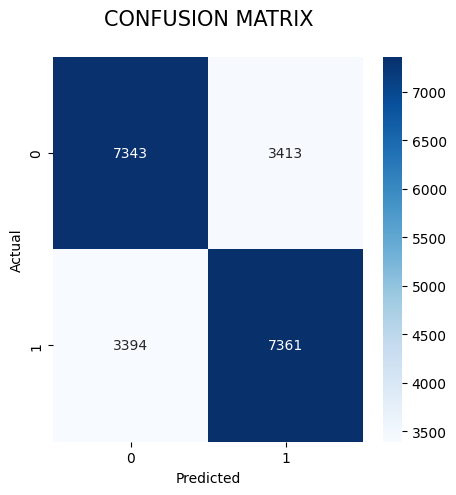

In [43]:
conf_mat = metrics.confusion_matrix(test_labels_loaded, test_predictions)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

In [44]:
print(metrics.classification_report(test_labels_loaded, test_predictions))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     10756
           1       0.68      0.68      0.68     10755

    accuracy                           0.68     21511
   macro avg       0.68      0.68      0.68     21511
weighted avg       0.68      0.68      0.68     21511



---------------------

In [15]:
# # Load embeddings from the file
final_test_embeddings_loaded1 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_final_test_data_ruatd_sber_20000.pkl')
final_test_embeddings_loaded2 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_final_test_data_ruatd_sber_20000_40000.pkl')
final_test_embeddings_loaded3 = load_embeddings('/kaggle/input/ruatd-sbert-embs-with-pooling/embeddings_final_test_data_ruatd_sber_40000_.pkl')

final_test_embeddings_np1 = final_test_embeddings_loaded1.numpy()
final_test_embeddings_np2 = final_test_embeddings_loaded2.numpy()
final_test_embeddings_np3 = final_test_embeddings_loaded3.numpy()

In [17]:
final_test_embeddings_np1.shape

(20000, 1024)

In [18]:
final_test_embeddings = np.vstack([final_test_embeddings_np1, final_test_embeddings_np2, final_test_embeddings_np3])

In [19]:
final_test_embeddings.shape

(64533, 1024)

In [20]:
with open('/kaggle/input/ruatd-sbert-embs-with-pooling/logistic_regression_model_ruAtd_sbert.pkl', 'rb') as file:
    classifier = pickle.load(file)

In [21]:
preds = classifier.predict(final_test_embeddings)

In [29]:
new_targets = []
for each in preds:
    if each==0:
        new_targets.append('H')
    else:
        new_targets.append('M')

In [33]:
final_preds = pd.concat([final_test_data['Id'],
    pd.DataFrame(new_targets)], axis=1)

In [34]:
final_preds = final_preds.rename(columns={0: 'Class'})

In [35]:
final_preds

,Id,Class
0,8,M
1,12,H
2,14,M
3,16,M
4,17,H
...,...,...
64528,215100,H
64529,215101,H
64530,215103,M
64531,215108,M


In [36]:
final_preds.to_csv('subm_embs_sbert_with_p.csv', index=False)